# CH413 Computational Workshop 3: 
# Predicting the stability of an oxygen-covered diamond(110) surface

**ATTENTION** This notebook contains our class workshop (Parts 1 and 2) **AND** the homework assignment (Part 3).

This workshop has 3 parts.
* **Part 1:** Calculating the adsorption energy of oxygen on diamond(110): 
* **Part 2:** Calculating stability phase diagrams for different oxygen-covered diamond phases 
* **Part 3:** Assessed Assignment

This notebook contains only the Parts 1 and 2.

To save existing calculations, you can assign variables to the numbers you've already calculated. This way you don't have to recalculate everything if you take breaks.


### IMPORTANT - how to use this notebook
* This notebook is read-only, so **you do need to make a copy first** (you can pick any name as this notebook is for your learning/reference only and won't be assessed)!
* The notebook should not raise any errors, otherwise you won't be able to submit it. So, double-check for the source of errors and ask for help if needed.

### For further instructions on the assignment, see Part 3

<b>If you have any issues, contact Bora Karasulu (bora.karasulu@warwick.ac.uk)</b>

## Part 0. Introduction

<p>In this workshop, we will be exploring Density Functional Theory (DFT) calculations and their application in surface chemistry. We will do this using the ASE and GPAW packages (Click on images to go to webpages):</p>

<div style="display: flex;">
  <div style="flex: 40%;padding: 15px;">
    <a href="https://wiki.fysik.dtu.dk/ase/"><img src="./Part3_DFT/ase.png" width="80%"></a>
  </div>
  <div style="flex: 40%;padding: 15px;">
     <a href="https://wiki.fysik.dtu.dk/gpaw/"><img src="./Part3_DFT/gpaw.png" width="100%"></a>
  </div>
</div>


<br> 

###  Part 0.1 - Atomic Simulation Environment (ASE)
<b>ASE</b> is a Python package that provides simple workflows for computational chemistry and materials modeling tasks and interfaces with many different DFT software packages. ASE uses Python computer language to define what atoms and molecules are. It defines representations for molecules and materials, allows us to create, visualise, and manipulate them. It is also interfaced with main external DFT and other computational chemistry codes (actually more than 30 codes are currently supported, <a href="https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html#module-ase.calculators"> see this for a full list </a>). Here we will use GPAW among those available interfaces.

Please take the time to have a look at some ASE tutorials (<a href="https://wiki.fysik.dtu.dk/ase/tutorials/tutorials.html">here</a>)

ASE packages can be installed very conveniently within the Python3 environment using the PiP tool, e.g. running 'pip install ase --user' in the command line.

For example, we can define an oxygen molecule in ASE and visualise it conveniently inside this Jupyter notebook:

In [4]:
from ase import Atoms

#We define a so-called Atoms object ("collection of atoms") with the chemical formula o2
o2 = Atoms('O2', 
          positions = [
              [0,0,0],   #x,y,z positions of 1st oxygen atom
              [0,0,1.0], #x,y,z positions of 2nd oxygen atom at distance 1 Angstrom from 1st atom, molecule oriented in z direction
          ],
          )

Let's visualise this Atoms object

In [5]:
#OPTION 1: Use the built-in visualiser in ASE
from ase.visualize import view

#If you don't put the viewer='x3d' option, it doesn't work on the Jupyter notebook as an external x11-terminal window (ASE-GUI) needs to opened.
view(o2, viewer='x3d')
#After executing this cell, you can interact with the viewer, rotate the molecule etc.

#TASK: try using 'ase-gui' command in the command line to access a more interactive ASE visualisation and modelling tools.


In [6]:
#OPTION 2: You can also set the viewer='ngl' option, which will call the NGL viewer interface (as introduced by Livia) instead of ASE-GUI (x3d); 
view(o2, viewer='ngl')
#FYI: you could also try the long-way by properly importing the nglviewer as following (simply uncomment the following line):
#import nglview as nv # visualisation
#myview = nv.show_ase(o2)
#myview.add_unitcell()
#myview

In [7]:
#OPTION 3: another way to visualize molecules with imolecule and openbabel
#This looks slightly nicer on Jupyter Notebooks than the other options, by drawing bonds etc (but requires extra packages)
#We will use this option below, so be sure to always import these packages.
from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
from openbabel import pybel
pybel.ipython_3d = True

#We just pass the o2 object to this visualisation function
a2p(o2)

#Normally (when using command-line for doing DFT calculations using the ASE framework), I would recommend using 
#the 'ase-gui' command, providing a better control over visualisation and structure building/modifying options, 
#which is compatible with many file formats.

We can use ASE to generate surface slab structures. Please take a look at this short ASE tutorial on <a href="https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html">Au on Al(001) </a>. This shows a worked example for Nudged-Elastic-Band (NEB) calculation to determine the energy profile with the activation energy for the Au atom diffusion from one hollow site of Al(100) surface to another.

**TASK** After going through the tutorial, pick the relevant commands to generate the Au atom on Al(100) surface and paste them into the following cell (don't forget the import commands) and visualise the structure (use the same command as above).

In [8]:
##Use this code cell to create and visualise the Au on Al(100) system
from ase.build import fcc100, add_adsorbate

## INSERT HERE  

# 2x2-Al(001) surface with 3 layers and an
# Au atom adsorbed in a hollow site:
slab = fcc100('Al', size=(2, 2, 3))
add_adsorbate(slab, 'Au', 1.7, 'hollow')
slab.center(axis=2, vacuum=4.0)


####

#Now visualise the slab (Note: uncomment to check different options)
#view(slab,viewer="x3d")
#view(slab,viewer="ngl")
a2p(slab)

##you can also repeat the slab unit cell for a better visibility
#slab=slab.repeat((2,2,1)) #2x2
##or simply use
#a2p(slab*[2,2,1])

#If you have correctly inserted statements from the ASE tutorial,
#you should be able to see the surface, the molecule, and the edge of the unit cell

### Part 0.2 - GPAW

One of the software packages that can be interfaced with ASE is <b>GPAW</b> (an abbreviation for "Grid-based Projector-Augmented-Waves", which is the plane-wave basis set that GPAW uses). It is a Python/C++-based DFT code and can also handle the real-space, and Linear combination of atomic orbitals (LCAO) basis sets (as discussed in Lecture 4). GPAW basis describes the Kohn-Sham DFT wave functions with a basis set that splits the core electrons and the valence electrons. Core electrons are "frozen" and described with projector-augmented waves (PAWs) - a formalism that is closely related to the pseudopotentials we discussed in the lecture. The valence electron states are described with a basis set. That basis set in GPAW is usually a uniform real-space grid. Each grid point is a "basis function". You can read more about this <a href="https://wiki.fysik.dtu.dk/gpaw/algorithms.html">here</a>.

GPAW defines a so-called "*calculator*" - a DFT engine that provides energies and forces to the "*atoms*" object. 
ASE and GPAW are linked by providing a GPAW calculator to the ASE atoms object.
<br>
Let's use GPAW to calculate the properties of the oxygen molecule:

**REMEMBER:** If you restart from somewhere in the middle you need to first execute cells above that contain import statements or previous code that is required, e.g. o2 needs to be defined at this point


In [10]:
from ase import Atoms
from ase.io import write
from gpaw import GPAW

#Let's use the o2 molecule we set up before

print(o2) # This just shows that 'o2' is an Atoms object

Atoms(symbols='O2', pbc=False)


**ATTENTION**
The print function shows that the o2 molecule currently doesn't have any periodic boundary conditions defined (pbc=False). We cannot define a grid or plane-wave basis without periodic boundary conditions, because we need Born-von-Karman conditions and an infinite lattice (see Lecture 4). That means we first need to put the oxygen molecule in a big box (a so-called supercell).

In [11]:
#Let's take the o2 molecule and put it into a box
#We simply "give" the molecule a unit cell defined by three lattice vectors a1, a2, a3
from ase import Atoms

a = 6.0
cell = [
    [a,0,0], #a1
    [0,a,0], #a2
    [0,0,a], #a3
]
o2 = Atoms('O2', 
          positions = [
              [0,0,0],   #x,y,z positions of 1st oxygen atom
              [0,0,1.0], #x,y,z positions of 2nd oxygen atom at distance 1 Angstrom from 1st atom, molecule oriented in z direction
          ],
          )

#This is a cubic box with 6 Angstrom side length in all directions
o2.set_cell(cell) #pass the cell to the o2 atoms object
#Now we set the periodic boundary conditions to True in all three directions and we center the molecule in the cell
o2.set_pbc([True,True,True])
o2.center()
print(o2)
#view(o2,viewer="ngl") #'x3d' needed

#When we visualize o2, we can now see a box around it (Hurray!)
a2p(o2)

Atoms(symbols='O2', pbc=True, cell=[6.0, 6.0, 6.0])


Now we create a GPAW calculator instance within ASE using the built-in Python interface of GPAW. See <a href="https://wiki.fysik.dtu.dk/gpaw/documentation/basic.html#parameters">here</a> and <a href="https://wiki.fysik.dtu.dk/gpaw/">here</a> for full ist of keywords and options.

In [13]:
from gpaw import GPAW,PW

#Let's set up a GPAW calculator. Here we need to choose numerical settings as discussed in the lecture.
calc_o2 = GPAW(
            mode ='fd', #The default is finite difference,This means that the wave functions will be expanded on a real space grid. Other options are: 'pw' and 'lcao' 
            #mode=PW(600), #we can alternatively use only planewaves as basis functions, which would also allow us to calculate the stress hence the optimise the cell paramters.
            h=0.25, # basis set defined by a grid spacing in Angstrom
            xc="PBE", #choice of exchange-correlation functional
            kpts=(1,1,1), #k-grid sampling: here we only pick a single K point (the Gamma point)
            #because we want to describe oxygen as a single molecule
           )

#h value: The grid spacing defines the basis set. We chose a grid spacing of 0.25 Angstrom in all directions. 
#The smaller the number, the finer the grid and the better the basis set is converged, 
#but also the more computationally costly the calculation becomes.

#Now we "pass" the calculator to the ASE atoms instance for the o2 molecule
o2.set_calculator(calc_o2)

#Now we calculate the total energy for O2 using the GPAW calculator with the chosen settings. Please note that this is a single-point energy calculation using the initial geometry as defined above.
etot_o2 = o2.get_potential_energy()
print("Final total energy: ", etot_o2)
#When running this cell, you should see BELOW a pop-up of the output file, where you can follow the calculation.


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  20.1.0
 |___|_|             

User:   mssmkc@rem123.csc.warwick.ac.uk
Date:   Tue Dec  6 22:04:37 2022
Arch:   x86_64
Pid:    204069
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.20.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.19.2)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.5.2)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OMP_NUM_THREADS: 1

Input parameters:
  h: 0.25
  kpts: [1 1 1]
  xc: PBE

Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                         0.106     0.000   0.0% |
 Atomic:                             0.049     0.000   0.0% |
  XC Correction:                     

**TASK**
Carefully study the output that was generated by this DFT calculation.
Look for following things:
* A basic description of all settings and the geometry
* The actual DFT calculation, where the Kohn-Sham (KS) equations are solved iteratively with many self-consistent field (SCF) iteration steps
* The final total energy (in eV) and the energies and occupation numbers of the Kohn-Sham states

**After this, we can now also optimise the bond distance of the O$_2$ molecule:**

In [14]:
#we import a geometry optimisation algorithm from ASE package (among many others available)
from ase.optimize import BFGS
#we apply it to the o2 molecule object (which contains the GPAW calculator)
dyn = BFGS(o2,trajectory='o2_opt.traj')  
#we run the optimisation, but before that, we pipe the GPAW text output into a file, so we're not overwhelmed by the GPAW output
calc_o2.set(txt="o2_gpaw.txt")
dyn.run(fmax=0.05)
#It might take a while (~1 min) to finish... Also note that if you run it again it will restart from the last point, so will take only one step to converge this time.

etot_o2 = o2.get_potential_energy() # let's update the new optimised o2 energy


      Step     Time          Energy         fmax
BFGS:    0 22:04:49       -7.640226       35.1831
BFGS:    1 22:04:52       -9.742795        7.0838
BFGS:    2 22:04:54      -10.152531        5.0952
BFGS:    3 22:04:58      -10.397141        4.3579
BFGS:    4 22:05:01      -10.476615        1.7054
BFGS:    5 22:05:04      -10.500777        0.3808
BFGS:    6 22:05:06      -10.501773        0.0740
BFGS:    7 22:05:08      -10.501812        0.0045


In [15]:
#Let's visualise the trajectory
import ase.io
steps=ase.io.read('o2_opt.traj',index=':') #read the trajectory from the .traj file, index option is needed for reading all time steps, by default last step is read.

#a2p(steps) #does not support multi structures
#view(steps,viewer='x3d') #does not support multi structures
view(steps,viewer='ngl')


In each step of the geometry optimisation, the algorithm calculates the energy and forces from DFT and changes the geometry towards lower energy. This is repeated until the maximum force acting on the atoms is reduced to below the threshold value fmax=0.05 eV/Angstrom. Let's check out the optimised bond distance:

In [16]:
print('bond distance in Angstrom', o2.get_distance(0,1))
etot_o2 = o2.get_potential_energy() # let's update the new optimised o2 energy
print('etot_o2', etot_o2)

bond distance in Angstrom 1.2127500538508489
etot_o2 -10.501811557685478


Before we start with the main tasks, let's look at the convergence concept using this simple O2 molecular system. Here we checked the convergence of the total energy with respect to the numerical basis-set grid spacing parameter. You may notice that the  single point energy calculation takes longer with lower grid spacing (means more grid points, more complex caluclations).

**Attention**: As a rule of thumb, you should only do a convergence test for a single parameter (e.g. plane-wave cutoff energy, Ecut, kpoint grid, basis-set grid spacing, etc.) at a time

A sample convergence test input can be found on the GPAW website <a href="https://wiki.fysik.dtu.dk/gpaw/exercises/stress/stress.html#converging-the-plane-wave-cutoff">click here.</a>

0.3 -5.328682492171105
0.25 -10.501811548834274
0.2 -9.939621667336196
0.18 -9.666361531572177
0.16 -9.558548680484295
0.14 -9.479267656107194
0.12 -9.457642067893415
0.1 -9.44854176024439
0.08 -9.444958769025389


<IPython.core.display.Javascript object>


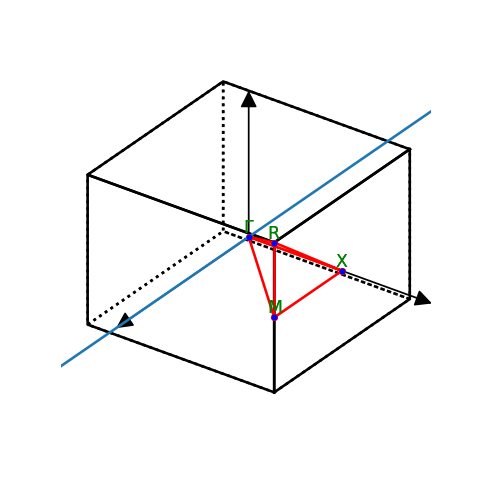

In [17]:
#Doing a convergence test against the h spacing.

import matplotlib.pyplot as plt
%matplotlib notebook 
#this gives us an interactive graph with a cross hair (using the standard MatPlotLib package)

from gpaw import PW,GPAW
o2_copy=o2.copy()#let's preserve the original o2 object.

Es=[] #store the total energy value for each h value.
#for x in [100, 200, 300, 400, 500, 600, 700, 800]: #For checking the cutoff energy convergence for instance, to use this you need to switch to 'mode=PW(x)'
hs=[0.30,0.25, 0.20, 0.18, 0.16, 0.14, 0.12,0.10,0.08] #TASK: try adding more steps to the end points to check the trends.
for x in hs:
    calc = GPAW(
                #mode=PW(x),
                mode='fd',
                h=x,
                xc='PBE',
                kpts=(1,1,1), #As we are simualting an isolated molecule, we need to include a single point, which the Gamma (center) point.
                txt='convergence_%s.txt' % x)

    o2_copy.calc = calc
    Es.append(o2_copy.get_potential_energy())
    print(x, Es[-1])

#Now do the plotting
plt.plot(hs,Es)
plt.xlim(max(hs),min(hs)) #Reverse the x axis, as the lower the grid size, the higher the accuracy is.
plt.xlabel('Basis-set grid spacing [1/A]') 
#by the way, this is how you get latex math into the label, dont forget the r in front
plt.ylabel(r'Total Energy [eV]')
plt.show()

One can see that the total energy sufficiently converges when using `Grid Spacing <= 0.1 1/A`. You should use a similar strategy for the other simulation models and parameters in the assessment.

### Let's see how we can do an electronic structure calculation (i.e. electronic DOS and band structure) for the bulk Silicon

You can compare your results to the ones documented on the Materials Project Database website for this specific Si phase (see <a href="https://materialsproject.org/materials/mp-149/">here</a>). The ASE/GPAW tuorial on electronic DOS band structure can also be useful (See <a href="https://wiki.fysik.dtu.dk/ase/gettingstarted/tut04_bulk/bulk.html">here</a>).


In [39]:

#First we build the bulk Silicon
from ase.build import bulk
from ase import Atoms
from ase.visualize import view
from ase.io import read,write
from gpaw import GPAW,PW

from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
from openbabel import pybel
pybel.ipython_3d = True


#Either use the built-in function of ASE to build bulk crystal structures 
#Si=bulk('Si',crystalstructure='fcc',a=5.5, cubic=1)#.repeat((2,2,2)) #by defatul this creates a primitive (non-orthogonal) unit cell for the given material, by adding cubic or orthorhombic options to get the othogonal (non-primitive) unit cells

#Or use the structure you get from Materials Project database, check
#https://materialsproject.org/materials/mp-149/
Si=read('Part3_DFT/Si_mp-149_conventional_standard.cif')

#Visualise the Si structure for fun!
#view(Si, viewer='ngl')
#view(Si, viewer='x3d')
a2p(Si)



In [40]:
#Let's set up a GPAW calculator and optimise the input geometry. 
#Now we switch to planeWaves (which allows us to also optimise the cell paramters by providing the Stress Tensor, which is not available with finitie difference or real-grid option)
calc = GPAW(
            #mode ='fd', #The default is finite difference,This means that the wave functions will be expanded on a real space grid. Other options are: 'pw' and 'lcao' 
            mode=PW(600), #we need to use planewaves to be able to claculate the stress hence the optimise the cell paramters.
            #h=0.25, # basis set defined by a grid spacing in Angstrom
            xc="PBE", #choice of exchange-correlation functional
            kpts=(6,6,6), #k-grid sampling: here we only pick a single K point (the Gamma point)
            #because we want to describe oxygen as a single molecule
           )


#Now we "pass" the calculator to the ASE atoms instance for the o2 molecule
Si.set_calculator(calc)

#Now we calculate the total energy for O2 using the GPAW calculator with the chosen settings. Please note that this is a single-point energy calculation using the initial geometry as defined above.
etot_Si = Si.get_potential_energy()
print("initial E_tot", etot_Si)

#we import a geometry optimisation algorithm from ASE package (among many others available)
from ase.optimize import BFGS

#we now apply this BFGS to the Si Atoms object (which contains the GPAW calculator)
dyn = BFGS(Si,trajectory='Si_opt.traj',restart='lbfgs.pckl')  

#The ase.constraints.ExpCellFilter allows us to optimise cell parameters and atomic positions simultaneously. It does this by exposing the degrees of freedom to the optimiser as if they were additional positions — hence acting as a kind of filter. We use it by wrapping it around the atoms:
#from ase.constraints import ExpCellFilter
#dyn = BFGS(ExpCellFilter(Si),trajectory='Si_opt.traj',restart='lbfgs.pckl')  

#we run the optimisation, but before that, we pipe the GPAW text output into a file, so we're not overwhelmed by the GPAW output
calc.set(txt="Si_gpaw.txt")
dyn.run(fmax=0.05)
#It might take a while (~1 min) to finish... Also note that if you run it again it will restart from the last point, so will take only one step to converge this time.

etot_Si = Si.get_potential_energy() # let's update the new optimised o2 energy
print("Final Etot", etot_Si)


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  20.1.0
 |___|_|             

User:   mssmkc@rem123.csc.warwick.ac.uk
Date:   Tue Dec  6 23:05:50 2022
Arch:   x86_64
Pid:    204069
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.20.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.19.2)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.5.2)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OMP_NUM_THREADS: 1

Input parameters:
  kpts: [6 6 6]
  mode: {ecut: 600.0,
         gammacentered: False,
         name: pw}
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Si-setup:
  name: Silicon
  id: ee77bee481871cc2cb65ac61239ccafa
  Z: 14
  valence: 4
  core: 10
  charge: 0.0
  f

CUB(a=5.46873)
CUB(a=5.46873)
  Variant name: CUB
  Special point names: GXRM
  Default path: GXMGRX,MR

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    X   0.0000  0.5000  0.0000
    R   0.5000  0.5000  0.5000
    M   0.5000  0.5000  0.0000

Computed Ef: 5.420 eV
BandPath(path='GXMRG', cell=[3x3], special_points={GMRX}, kpts=[100x3])


<IPython.core.display.Javascript object>


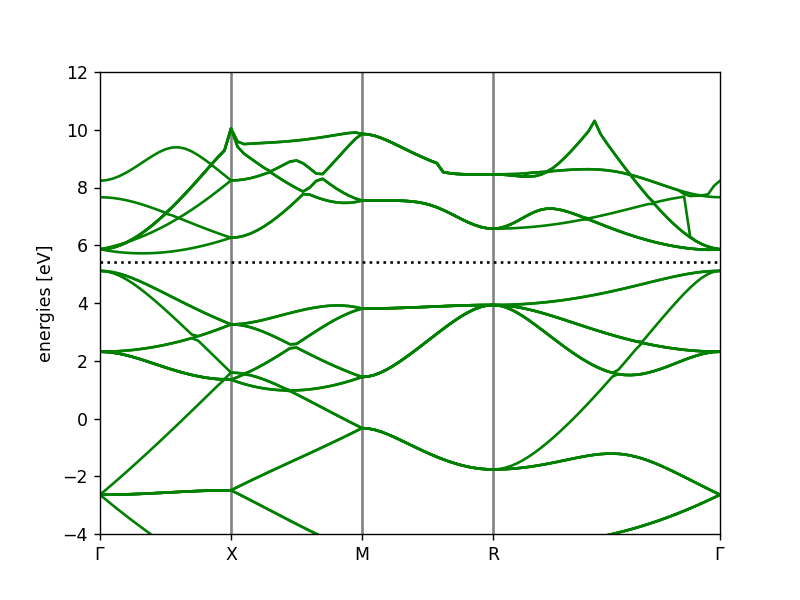

<AxesSubplot:ylabel='energies [eV]'>

In [41]:
from ase.dft.dos import DOS
import matplotlib.pyplot as plt

#Note: if you are re-running this cell, you also need to re-run the previous one, 
#as this one needs a converged SCF as done in the previous step 
#or do another SCF calculation in this cell (as given below)
etot_Si = Si.get_potential_energy()

#This part details and visualises the 1st Brioullin Zone (BZ) for the given input crystal structure
print(Si.cell.get_bravais_lattice())
lat = Si.cell.get_bravais_lattice()
print(lat.description())
lat.plot_bz(show=True)


#The Fermi Level is computed automatically by GPAW and passed on to the ASE object.
Ef=calc.get_fermi_level()
print ("Computed Ef: %.3f eV"%Ef)

#Density of states (DOS) calculation using an equally distributed set of K points/vectors
dos = DOS(calc, npts=100, width=0)
energies = dos.get_energies()
weights = dos.get_dos()
ax = plt.gca()
ax.plot(energies, weights)
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('DOS [1/eV]')
plt.show()

#if special_path is set to None,then it will be automatically determined by ASE based on the symmetry of the Bravais lattice.
path = Si.cell.bandpath('GXMRG', npoints=100) #density=10) #as given in Materials Project
#path = Si.cell.bandpath(None, npoints=100)
print(path)

#Now used the converged electron density from the DOS calculations and apply this subset of special high-symmetry K vectors
calc.set(kpts=path, fixdensity=True, symmetry='off')

Si.get_potential_energy()
bs = calc.band_structure()
bs.plot(emin=-4,emax=12)

###
### Or you could draw them altogether, just uncomment everything
#fig = plt.figure(1, figsize=(7, 4))
#ax = fig.add_axes([.12, .07, .67, .85])

#bs.plot(ax=ax, emin=-4.0, emax=4.0,show=1)
#bs.plot(ax=ax, show=1)

#dosax = fig.add_axes([.8, .07, .17, .85])
#dosax.fill_between(weights, energies, y2=0, color='grey',
#                   edgecolor='k', lw=1)

#dosax.set_ylim(0, 4.0)
#dosax.set_yticks([])
#dosax.set_xticks([])
#dosax.set_xlabel("DOS", fontsize=18)



**TASK:** try to plot the electronic band structure and DOS for bulk diamond.


You can also do phonon calculations, as shown for Si-fcc structure below. As it takes forever on a single core, as it needs to do 6\*N single-point energy calculations (N being the number of atom in the unit cell), using a supercell of the input structure you provide. 
Given for completeness/info, do it at leisure. More information can be found <a href="https://wiki.fysik.dtu.dk/ase/ase/phonons.html#module-ase.phonons">here</a>.

In [ ]:
from ase.build import bulk
from ase.phonons import Phonons
from gpaw import GPAW, FermiDirac
from ase.io import read,write

#Different options to create a bulk Si structure
atoms=bulk('Si',crystalstructure='fcc',a=5.5, cubic=1)#.repeat((2,2,2)) #by defatul this creates a primitive (non-orthogonal) unit cell for the given material, by adding cubic or orthorhombic options to get the othogonal (non-primitive) unit cells
#atoms = bulk('Si', 'diamond', a=5.4)
#atoms=read('Part3_DFT/Si_mp-149_conventional_standard.cif')
#atoms=Si #read the Si Atoms object from the previous cells.


calc = GPAW(
            mode=PW(400), #we need to use planewaves to be able to claculate the stress hence the optimise the cell paramters.
            xc="PBE", #choice of exchange-correlation functional
            kpts=(2,2,2), #k-grid sampling: here we only pick a single K point (the Gamma point)
           )


#Now we "pass" the calculator to the ASE atoms instance for the o2 molecule
atoms.set_calculator(calc)


#Create a NxNxN supercell from the input cell to be used in the finite differences approach in computing the 2nd derivatives (force constants)
N=2 
ph = Phonons(atoms, calc, supercell=(N, N, N),delta=0.05)
ph.run()


# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
#ph.read(method='frederiksen', acoustic=True)
ph.clean()

path = atoms.cell.bandpath('GXMRG', npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

# Plot the band structure and DOS:
import matplotlib.pyplot as plt  # noqa
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([.12, .07, .67, .85])

emax = 0.035
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

Alright, so much for the basics. Let's get into the meat of things. Now we go through the two remaining parts:
* <b>Part 1</b>: Calculating the adsorption energy of oxygen on diamond(110) with DFT
* <b>Part 2</b>: Calculating stability phase diagrams for oxygen-covered diamond phases



## Part 1: Calculating the adsorption energy of oxygen on diamond(110): 

Diamond, beyond being shiny and expensive in some of its variants, is an interesting material in chemistry and physics. Particularly for electrochemical applications, boron-doped diamond can be used as a versatile electrode material. Despite the decades of research work that exist on diamond and its bulk and surface properties, many details are not fully understood. For example the diamond(110) surface termination is known to be oxygen-terminated, but the nature of this termination is not fully clear. 
The following picture, shows some examples of possible oxygen functional groups that can sit on the carbon ridges that are exposed at the diamond(110) surface:

<img src="./Part3_DFT/diamond.png" width="100%">
Reference: Mackey et al., J. Phys. Chem. B 2001, 105, 3803-3812

To resolve this, we need to model different possible surface terminations of diamond surfaces and study, which are the energetically most favorable ones. Let's start by taking a look at a clean diamond(110) surface.


In [47]:
#Importing common packages.
from ase import Atoms
from gpaw import GPAW
from ase.io import read,write

from ase.visualize import view
from imolecule.atoms_to_pybel import atoms_to_pybel as a2p
from openbabel import pybel
pybel.ipython_3d = True


In [77]:

#The folder Part3_DFT/structures contains several different structure files that are preoptimised
clean_diamond = read('Part3_DFT/structures/clean_bdd.in') #Note: even though this is called bdd, this is actually a pure (non-boron-doped) diamond(110) surface
#the file contains a minimal surface unit cell of diamond(110) with a few layers of carbon atoms


#We can visualise the surface better by repeating it periodically in x and y direction
a2p(clean_diamond*[2,1,1])
#a2p(clean_diamond)


Here, one should note that ASE has very handy and versatile built-in tools for creating different types of material models (e.g. molecules, bulks, surfaces, nanotubes, nanoribbons, nanosheets, etc.). It is worth checking the ASE website (see <a href="https://wiki.fysik.dtu.dk/ase/ase/build/build.html">this</a> and the links therein).

In [49]:
#OPTIONAL (again better to use the first structure, being pre-optimised, which converges quicker)
#Or you may prefer to use the built-in building tools within ASE...
from ase.build import surface
s1 = surface('C', (1, 1, 0), 3) #build 3 layers
s1.center(vacuum=5, axis=2) #add a vacuum padding of 5A in each direction along the C axis
clean_diamond=s1

#view(clean_diamond, viewer="x3d")
a2p(clean_diamond)



As covered in Lecture 5, **the adsorption energy per oxygen atom** is defined as
$$ E_{\mathrm{ads}}=-\frac{1}{N_O}\left( E^{\mathrm{slab}}_{\mathrm{surf}}(N_O,N_M)-\left( E^{\mathrm{clean}}_{\mathrm{surf}}(0,N_M) + \frac{N_O}{2}E^{\mathrm{total}}_{O_2}  \right)  \right) $$

That means we need to calculate the energy of the isolated oxygen molecule, the clean diamond surface, and the oxygen-covered diamond surface. We already calculated the oxygen molecule, let's calculate the clean diamond surface energy.

In [78]:
#Let's set up a new calculator for the clean surface
calc_clean = GPAW(h=0.25, #basis grid spacing
             xc="PBE", 
             kpts=(2,2,1), #a 2x2x1 Monkhorst-Pack grid. 2 k points in a1 and 2 k points in a2 direction
                  #we dont need to do k sampling perpendicular to the surface, as we want this to be the 
                  #'non-periodic' surface direction
           )


clean_diamond.set_calculator(calc_clean)
etot_clean = clean_diamond.get_potential_energy()
print('etot_clean', etot_clean) #before the geometry optimisation
#dont be surprised if the calculation takes a bit (still < 1min). You can follow the convergence in the output window


#we import a geometry optimisation algorithm from ASE package (among many others available)
from ase.optimize import BFGS
#we apply it to the atoms object (which contains the GPAW calculator)
dyn = BFGS(clean_diamond,trajectory='clean_opt.traj')  
#we run the optimisation, but before that, we pipe the GPAW text output into a file, so we're not overwhelmed by the GPAW output
calc_clean.set(txt="clean_gpaw.txt")
dyn.run(fmax=0.05)
#It might take a while (~1 min) to finish... Also note that if you run it again it will restart from the last point, so will take only one step to converge this time.

etot_clean = clean_diamond.get_potential_energy()
print('etot_clean', etot_clean) #after the geometry optimisation



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  20.1.0
 |___|_|             

User:   mssmkc@rem123.csc.warwick.ac.uk
Date:   Wed Dec  7 00:19:58 2022
Arch:   x86_64
Pid:    204069
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.20.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.19.2)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.5.2)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OMP_NUM_THREADS: 1

Input parameters:
  h: 0.25
  kpts: [2 2 1]
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

C-setup:
  name: Carbon
  id: 4aa54d4b901d75f77cc0ea3eec22967b
  Z: 6
  valence: 4
  core: 2
  charge: 0.0
  file: /opt/gpaw-setups/C.PBE.gz
  compensation charges: gauss, rc=0

Alright, now let's check out one of the oxygen-covered phases shown in the above figure. Let's start with a keto group. You'll find different preoptimised diamond structures in the folder Part3_DFT/structures/:

In [79]:
#We will use the pre-optimised models of the oxygenated diamond(110) surfaces, however you should be able to prepare them yourselves.
diamond_ketone = read('Part3_DFT/structures/phase1.in')
print(diamond_ketone) #pay attention to the chemical composition (you should expect an additional oxygen)

#Visualise the structure
#view(diamond_ketone,viewer='x3d')
a2p(diamond_ketone)
#You can repeat the unit cell for a better visibility
#a2p(diamond_ketone*[5,5,1])



Atoms(symbols='C10O', pbc=True, cell=[2.52594, 3.5722179, 18.10376])


In [52]:
#Another way to create oxygenated diamond(110) surfaces is by using the built-in functions of ASE 
#We add an adsorbate (Oxygen atom), starting from the clean surface
from ase.build import add_adsorbate

print(clean_diamond)
#As the 'add_adsorbate' function works ad hoc (i.e. does not return any variable), 
#we make a copy of clean_diamond not to spoil it. 
diamond_ketone = clean_diamond.copy() 
add_adsorbate(slab=diamond_ketone,adsorbate='O',height=1.0,position=(0,0)) 
#You need to fiddle around with the xy positions to create different oxygenated diamond surfaces
#TASK: figure out how to add an O2 molecule using 'add_adsorbate' to create the peroxide-terminated surfaces.

print(diamond_ketone) #pay attention to the chemical composition (you should expect an additional oxygen)

#view(diamond_ketone,viewer='x3d')
a2p(diamond_ketone)#*[5,5,1])

#Another option for a more interactive modelling would be to use 'ase-gui' (GUI from the ASE package) 
#or external visualisation software (Avogadro, VESTA) 


#Note: as the first structure (cell above) is a pre-optimised structure, 
#it will converge in fewer steps (24 steps with the provided settings) 
#than the current one.


Atoms(symbols='C24', pbc=[True, True, False], cell=[5.048742417671949, 3.57, 16.31092802208994], calculator=GPAW(...))
Atoms(symbols='C24O', pbc=[True, True, False], cell=[5.048742417671949, 3.57, 16.31092802208994])


Let's set up a new calculator for the keto phase slab...

In [55]:
calc = GPAW(h=0.25, 
             xc="PBE", 
             kpts=(2,2,1), 
           )

diamond_ketone.set_calculator(calc)
etot_keto = diamond_ketone.get_potential_energy()
print('etot_keto', etot_keto) #before the geometry optimisation

#Don't forget to relax the geometry with your new DFT settings.

#we import a geometry optimisation algorithm from ASE package (among many others available)
from ase.optimize import BFGS
#we apply it to the o2 molecule object (which contains the GPAW calculator)
dyn = BFGS(diamond_ketone,trajectory='keto_opt.traj')  
#we run the optimisation, but before that, we pipe the GPAW text output into a file, so we're not overwhelmed by the GPAW output
calc.set(txt="keto_gpaw.txt")
dyn.run(fmax=0.05)
#Optimisation of the first structure (phase1.in) might take a while (~5 min, ~25 steps) to finish... Also note that if you run it again it will restart from the last point, so will take only one step to converge this time.

etot_keto = diamond_ketone.get_potential_energy()
print('etot_keto', etot_keto) #after the geometry optimisation



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  20.1.0
 |___|_|             

User:   mssmkc@rem123.csc.warwick.ac.uk
Date:   Tue Dec  6 23:52:50 2022
Arch:   x86_64
Pid:    204069
Python: 3.7.3
gpaw:   /opt/anaconda/lib/python3.7/site-packages/gpaw
_gpaw:  /opt/anaconda/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /opt/anaconda/lib/python3.7/site-packages/ase (version 3.20.1)
numpy:  /opt/anaconda/lib/python3.7/site-packages/numpy (version 1.19.2)
scipy:  /opt/anaconda/lib/python3.7/site-packages/scipy (version 1.5.2)
libxc:  4.3.4
units:  Angstrom and eV
cores: 1
OMP_NUM_THREADS: 1

Input parameters:
  h: 0.25
  kpts: [2 2 1]
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

C-setup:
  name: Carbon
  id: 4aa54d4b901d75f77cc0ea3eec22967b
  Z: 6
  valence: 4
  core: 2
  charge: 0.0
  file: /opt/gpaw-setups/C.PBE.gz
  compensation charges: gauss, rc=0

In [56]:
#Let's visualise the trajectory
import ase.io
steps=ase.io.read('keto_opt.traj',index=':') #read the trajectory from the .traj file, index option is needed for reading all time steps, by default last step is read.

#a2p(steps)
view(steps,viewer='ngl')
#view(steps,viewer='x3d')

Now we can calculate the adsorption energy as defined by the equation above:

In [80]:
e_ads = -(etot_keto -(etot_clean+etot_o2/2) )
print ("Adsorption energy = %.2f eV"% e_ads)



Adsorption energy = 1.84 eV


The adsorption energy of this oxygen atom is about 1.84 eV per oxygen atom. We can also calculate this as adsorption energy per surface area by dividing by the surface area of the unit cell:

In [81]:
#The surface area of the unit cell is defined as the absolute value of the cross product between the a1 and a2 lattice vectors
cell = diamond_ketone.get_cell()
a, b, c = cell
#let's use the linear algebra operations in numpy for this
import numpy as np
area = np.linalg.norm(np.cross(a,b))
print('area %.2f A'%area) #Angstroem
#In this simple rectangular unit cell case, it would also have been enough to multiply 2.52 with 3.57
#print('area', a[0]*b[1])

#The adsorption energy per surface area and oxygen atom is:
print('e_ads per area %.2f eV/A' %(e_ads/area))

area 9.02 A
e_ads per area 0.20 eV/A


## Part 2: Calculating stability phase diagrams for different oxygen-covered diamond phases

Now that we have an adsorption energy, we can actually plot this as a function of chemical potential just as we discussed it in the lecture. Just as a reminder, here's the equation we use for that:

$$ Δ𝐺^{\mathrm{𝑎𝑑}} (Δ\mu_𝑂)≈\frac{𝑁_𝑂}{𝐴} 𝐸_{\mathrm{ads}}+(𝑁_𝑀−𝑁_𝑀^′ ) 𝐸_M^{bulk}+\frac{𝑁_𝑂}{𝐴} Δ\mu_𝑂 (𝑇,𝑝) $$

Let's plot this in a graph of $$ Δ𝐺^{\mathrm{𝑎𝑑}} vs. Δ\mu_𝑂 $$


We already have calculated the adsorption energy per surface area and oxygen atom:

In [82]:
print('e_ads per area = %.2f eV/Angstrom'%(e_ads/area))
e_b = e_ads/area


e_ads per area = 0.20 eV/Angstrom


The adsorption free energy is a straight line with the y-intercept defined by the adsorption energy per surface area and oxygen atom and the gradient defined by $N_O/A$:

In [84]:

#gradient = 1.0/area #1 oxygen atom per surface area
#print('gradient', gradient, '1/Angstrom')

#Probably better to automate the procedure by finding the total number of atoms with a specific type (e.g. O in this case).
N_O=len([at for at in diamond_ketone if at.symbol=='O'])
gradient = N_O/area 
print('gradient = %.2f 1/A'%gradient)


gradient = 0.11 1/A


### Let's generate that phase diagram. Here, we need to use the above equation to generate adsorption free energy values at certain values of chemical potential:

<IPython.core.display.Javascript object>


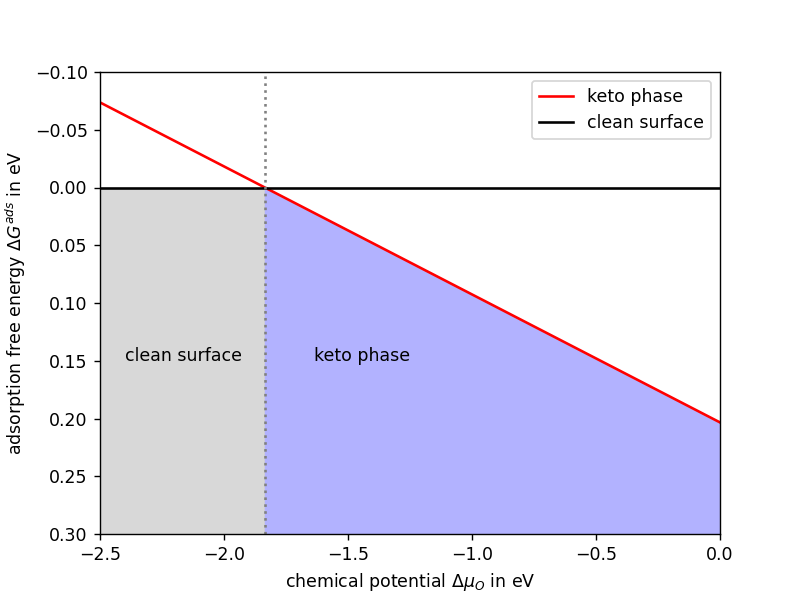

In [85]:
import matplotlib.pyplot as plt
%matplotlib notebook 
#this gives us an interactive graph with a cross hair (using the standard MatPlotLib package)

mu = np.arange(-2.50,0.1,0.1) # This generates mu values for the x-axis from -2.5 to 0 with a spacing of 0.1 eV

#let's generate the y value for our plot for a given set of mu values
#This is a very Pythonic ("integrated and neat") way to do that
Gads = [ e_b+x*gradient for x in mu ] #We loop over all mu values (calling each value x) and calculate the G_ads value via the above equation

################################################
#PLOTTING ROUTINES

plt.plot(mu,Gads, color='red',label='keto phase') #plot my vs. Gads

#we should also plot the line for the clean surface, which is a straight horizontal line at 0
plt.plot(mu, [0 for m in mu], color='black', label='clean surface')

#Let's set the x and y ranges of the plot.
#lets not forget that we want these plots to have inverted y axis, 
#because a bigger value means a more stable phase
xmin=-2.5;xmax=0.0
ymin=0.30;ymax=-0.10
plt.ylim(ymin,ymax) 
plt.xlim(xmin,xmax)

#We now assign the axis labels, and turn on the legend.
plt.xlabel(r'chemical potential $\Delta\mu_O$ in eV') 
#by the way, this is how you get latex math into the label, dont forget the r in front
plt.ylabel(r'adsorption free energy $\Delta G^{ads}$ in eV')
plt.legend()

#We add labels of the phases manually to the plot (just for demonstration purposes, not needed for calculations)
plt.text(xmin+0.1, 0.15,'clean surface') #add text to the graph
plt.text(-e_ads+0.2, 0.15,'keto phase')

#fancy area filling
plt.fill([xmin,-e_ads, -e_ads, xmin],[xmax,xmax, ymin,ymin],'gray', alpha=0.3) # let's fill the surface area for the clean surface
plt.fill([-e_ads,-e_ads,0.0,0.0],[ymin,0.0, Gads[-1],ymin],'b', alpha=0.3) #let's fill the surface area for phase 1 with a 

plt.axvline(-e_ads,color='gray',ls=':') #This is a vertical line to mark the intersection between the two phases

We can see that the two curves cross at about -1.84 eV oxygen chemical potential (${\Delta\mu_O}$). This is the point where the keto-terminated oxygenated diamond(110) surface becomes more stable than the clean diamond(110) surface.

Of course, we should also try to find out which other phases exist and how stable they are. 
